# Lab 4: Machine Learning with Vertex AI

Author: 
* Fabian Hirschmann
* Wissem Khlifi

Welcome back 👋😍. During this lab, you will train a machine learning model on the data set you already know. Then, we will create a MLOps pipeline to automate this process.

In a Jupyter Notebook, you can press `Shift + Return` to execute the current code junk and jump to the next one.

First, let's set a few variables and perform some Python imports

In [1]:
import random
random.seed(1337)

from google.cloud import aiplatform, bigquery
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

project = !gcloud config get-value project
PROJECT_ID = project[0]

REGION = "us-central1"
BQ_DATASET = "ml_datasets"
BQ_TABLE = "ulb_fraud_detection_dataproc"
BQ_SOURCE = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}"

The next chunk represents the source table in BigQuery we will be working with.

In [2]:
BQ_SOURCE

'astute-ace-336608.ml_datasets.ulb_fraud_detection_dataproc'

Let's have a look at the data.

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=f"{PROJECT_ID}-bucket")
bq = bigquery.Client(project=PROJECT_ID, location=REGION)

In [4]:
data = bq.query(f"SELECT * FROM `{BQ_SOURCE}`").to_dataframe()

Let's have a look at the data set in more detail.

In [5]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.00,0
1,14332.0,1.071950,0.340678,1.784068,2.846396,-0.751538,0.403028,-0.734920,0.205807,1.092726,...,-0.169632,-0.113604,0.067643,0.468669,0.223541,-0.112355,0.014015,0.021504,0.00,0
2,32799.0,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,0.125514,0.480049,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.00,0
3,35799.0,-0.769798,0.622325,0.242491,-0.586652,0.527819,-0.104512,0.209909,0.669861,-0.304509,...,0.152738,0.255654,-0.130237,-0.660934,-0.493374,0.331855,-0.011101,0.049089,0.00,0
4,36419.0,1.047960,0.145048,1.624573,2.932652,-0.726574,0.690451,-0.627288,0.278709,0.318434,...,0.078499,0.658942,-0.067810,0.476882,0.526830,0.219902,0.070627,0.028488,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,154599.0,0.667714,3.041502,-5.845112,5.967587,0.213863,-1.462923,-2.688761,0.677764,-3.447596,...,0.329760,-0.941383,-0.006075,-0.958925,0.239298,-0.067356,0.821048,0.426175,6.74,1
284803,90676.0,-2.405580,3.738235,-2.317843,1.367442,0.394001,1.919938,-3.106942,-10.764403,3.353525,...,10.005998,-2.454964,1.684957,0.118263,-1.531380,-0.695308,-0.152502,-0.138866,6.99,1
284804,34634.0,0.333499,1.699873,-2.596561,3.643945,-0.585068,-0.654659,-2.275789,0.675229,-2.042416,...,0.469212,-0.144363,-0.317981,-0.769644,0.807855,0.228164,0.551002,0.305473,18.96,1
284805,96135.0,-1.952933,3.541385,-1.310561,5.955664,-1.003993,0.983049,-4.587235,-4.892184,-2.516752,...,-1.998091,1.133706,-0.041461,-0.215379,-0.865599,0.212545,0.532897,0.357892,18.96,1


## Train model on Vertex AI Workbench (JupyterLab)

In [6]:
target = data["Class"].astype(int)
data.drop("Class", axis=1, inplace=True)

In [7]:
target.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data, target, train_size = 0.80)

In [9]:
clf = RandomForestClassifier(n_estimators=50, n_jobs=8)

In [10]:
clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=8)

In [11]:
preds = clf.predict(x_test)

The next chunk evaluates a binary classifier using the ROC curve and AUC. The ROC curve plots the true positive rate (TPR) vs. the false positive rate (FPR) at various thresholds. The AUC (area under the curve) is a single value between 0 and 1 that summarizes the model's performance, with higher values indicating better class separation.

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
metrics.auc(fpr, tpr)

0.8943565277191666

Next, we have a look at the confusion matrix, a table used to evaluate the performance of a classification model. It shows the counts of true positives, true negatives, false positives, and false negatives, providing insights into the model's accuracy, precision, recall, and overall performance.

What do you think about the performance of the model?

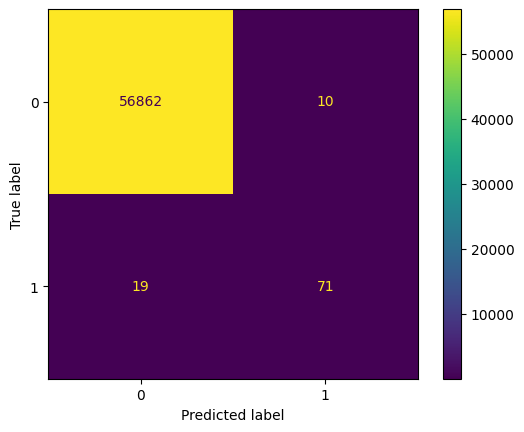

In [16]:
cm = metrics.confusion_matrix(y_test, preds, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

## Train and serve model on Vertex AI

Custom training jobs (`CustomJob` resources in the Vertex AI API) are the basic way to run your custom machine learning (ML) training code in Vertex AI. In this lab, we will use a `CustomTrainingJob`, which runs a `CustomJob` and registers our model the the Vertex AI model registry. From the registry, a model can be deployed to an endpoint for online prediction or be used for batch prediction.

Vertex AI offers [prebuilt containers](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) to serve predictions and explanations from models trained using the following machine learning (ML) frameworks:

* TensorFlow
* PyTorch
* XGBoost
* scikit-learn

To use one of these prebuilt containers, you must save your model as one or more model artifacts that comply with the requirements of the prebuilt container. These requirements apply whether or not your model artifacts are created on Vertex AI.

In our case, this means we will upload the serialized model with file name `model.joblib` to a location in Cloud Storage specified by the Vertex AI infrastructure (`AIP_MODEL_DIR`).

In [30]:
%%writefile train.py
#!/usr/bin/env python
# Train a Random Forest classifier on Vertex AI

import os
from pprint import pprint
pprint(dict(os.environ))
import joblib
import random
random.seed(1337)

from google.cloud import aiplatform, bigquery, storage
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

aiplatform.init(project=os.environ["CLOUD_ML_PROJECT_ID"],
                location=os.environ["CLOUD_ML_REGION"],
                staging_bucket=os.environ["AIP_MODEL_DIR"].split("/")[2])
bq = bigquery.Client(project=os.environ["CLOUD_ML_PROJECT_ID"])

# Prepare data
BQ_SOURCE = os.environ["CLOUD_ML_PROJECT_ID"] + ".ml_datasets.ulb_fraud_detection_dataproc"
data = bq.query(f"SELECT * FROM `{BQ_SOURCE}`").to_dataframe()
target = data["Class"].astype("int")
data.drop("Class", axis=1, inplace=True)

# Train model
clf = RandomForestClassifier(n_estimators=50, n_jobs=8)
clf.fit(data, target)

# Upload model to Cloud Storage
joblib.dump(clf, "model.joblib")
client = storage.Client(project=os.environ["CLOUD_ML_PROJECT_ID"])
bucket = client.get_bucket(os.environ["AIP_MODEL_DIR"].split("/")[2])
blob = bucket.blob("/".join(os.environ["AIP_MODEL_DIR"].split("/")[3:][:-1] + ["model.joblib"]))
blob.upload_from_filename("model.joblib")

Overwriting train.py


In [43]:
run_id = 1 if "run_id" not in vars() else run_id + 1
job = aiplatform.CustomTrainingJob(
    display_name=f"bootkon-run-{run_id}",
    script_path="train.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/sklearn-cpu.1-0:latest",
    model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest",
    requirements=["google-cloud-bigquery", "db-dtypes"], # python packages to install (pip style)
)

Let's run the training job! It will take around 6 minutes.

In [44]:
vertex_model = job.run(
    machine_type="n2-standard-8",
    replica_count=1,
)

While it is running, please go to the [`Training Jobs` in the Vertex AI Console](https://console.cloud.google.com/vertex-ai/training/training-pipelines) and click on the training job where you see **Status: Training**. The training job is based on a more general concept called `CustomJob` and adds functionality such as automatic model upload to Cloud Storage and registering the model to the model registry. Hence, to see details about the running job, click on the **Custom Job** and then **View Logs**.

Once the model has been trained, navigate to the [`Model Registry` in Vertex AI](https://console.cloud.google.com/vertex-ai/models). Click on `bootkon-model`. Can you find your newly created model artifact? Open the `VERSION DETAILS` tab and try to find your `model.joblib` artifact on Cloud Storage.

Next, create an endpoint to perform online predictions. The creation will take around 6min.

In [ ]:
endpoint = vertex_model.deploy(machine_type="n2-standard-2")

Go to [`Endpoints` in Vertex AI](https://console.cloud.google.com/vertex-ai/endpoints). Notice how the above command first creates an `Endpoint` and then deploys our `Model` to this endpoint.

Let's make a prediction:

Interested in how to make a prediction using the standard REST API? Go back to [`Endpoints` in Vertex AI](https://console.cloud.google.com/vertex-ai/endpoints) and click on `SAMPLE REQUEST` next to your endpoint.

## Train and serve model on Vertex AI through Vertex AI Pipelines